In [4]:
from keras.datasets import cifar10

In [5]:
CIFAR_DIR = 'C:/Users/Kaushik/Documents/Kaggle Datasets/Deep Learning/Convolution Neural Networks/cifar-10-batches-py/'

In [6]:
def unpickle(file):
    import pickle
    with open(file,'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [7]:
dirs=['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [8]:
all_data = [0,1,2,3,4,5,6]

In [9]:
print(CIFAR_DIR+dirs[0])

C:/Users/Kaushik/Documents/Kaggle Datasets/Deep Learning/Convolution Neural Networks/cifar-10-batches-py/batches.meta


In [10]:
all_data[0] = unpickle(CIFAR_DIR+dirs[0])
all_data[1] = unpickle(CIFAR_DIR+dirs[1])
all_data[2] = unpickle(CIFAR_DIR+dirs[2])
all_data[3] = unpickle(CIFAR_DIR+dirs[3])
all_data[4] = unpickle(CIFAR_DIR+dirs[4])
all_data[5] = unpickle(CIFAR_DIR+dirs[5])
all_data[6] = unpickle(CIFAR_DIR+dirs[6])

In [11]:
batches_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [13]:
batches_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [14]:
X= data_batch1[b"data"]

In [15]:
X= X.reshape(10000,3, 32,32).transpose(0,2,3,1).astype("uint8")

In [16]:
X[0].max()

255

In [17]:
(X[0]/255).max()

1.0

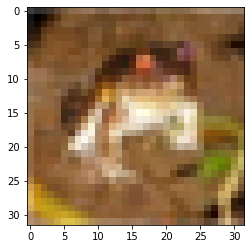

In [18]:
plt.imshow(X[0])

In [19]:
def one_hot_encode(vec,vals=10):
    '''For use to one hot encoder the 10- possible lables'''
    n = len(vec)
    out= np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [20]:
class CifarHelper():
    def __init__(self):
        self.i = 0
        
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
        
    def set_up_images(self):
        
        print("Setting up training images and labels..")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]),10)
        
        print("Setting up Test images and labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]),10)
        
    def next_batch(self,batch_size):
        x= self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y= self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i+batch_size) % len(self.training_images)
        return x,y

In [21]:
# before you run tf.session run these two
ch = CifarHelper()

In [22]:

ch.set_up_images()

Setting up training images and labels..
Setting up Test images and labels


In [26]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [28]:
x= tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true= tf.placeholder(tf.float32,shape = [None,10]) 
hold_prob = tf.placeholder(tf.float32)

In [29]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1,shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x,W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding = 'SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1],
                         strides = [1,2,2,1],padding='SAME')

def convolution_layer(input_x,shape):
    W= init_weights(shape)
    b= init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)

def normal_ful_layer(input_layer,size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size,size])
    b = init_bias([size])
    return tf.matmul(input_layer,W) + b

    

In [30]:
# Creating Layers
convo_1 = convolution_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [31]:
convo_2 = convolution_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [32]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [33]:
full_layer_one = tf.nn.relu(normal_ful_layer(convo_2_flat,1024))

In [34]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob = hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [35]:
# set output to y_pred
y_pred = normal_ful_layer(full_one_dropout,10)

In [36]:
y_pred

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [37]:
# Apply the Loss function
# create cross_entropy loss function

cross_entropy  = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [38]:
# Optimizer
# create optimizer using Adam Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate= 0.001)
train = optimizer.minimize(cross_entropy)

In [39]:
# create variable to initialize all the tf global variables
init = tf.global_variables_initializer()

In [40]:
# Graph session
# performing the training and test print outs in tf session and run the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
  
    for i in range(500):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict = {x:batch[0],y_true:batch[1],hold_prob:0.5})
        
        #print out a message every 100 steps
        if i%100 == 0:
            print('Currently on step'.format(i))
            print('Accuracy is: ')
            # Test the train model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob :1.0}))
            
            print('\n')
            

Currently on step
Accuracy is: 
0.1008


Currently on step
Accuracy is: 
0.3939


Currently on step
Accuracy is: 
0.466


Currently on step
Accuracy is: 
0.5081


Currently on step
Accuracy is: 
0.5355


